In [1291]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker

df = pd.read_csv('data/hw1_data.csv')
display(df)

,Participant id,"Observed FRS Score (Doctor, Week 0)","Observed FRS Score (Therapist, Week 0)","Observed FRS Score (Caregiver, Week 0)","Estimated FRS Score (In-clinic, Week 0)","Estimated FRS Score (Remote, Week 1)","Estimated FRS Score (Remote, Week 2)"
0,P1,3.5,3.5,3.0,3.66,3.99,3.61
1,P2,3.0,3.5,2.5,3.21,3.53,3.25
2,P3,2.5,2.0,2.0,2.67,3.02,2.70
3,P4,2.0,2.5,1.5,1.89,2.43,2.12
4,P5,3.0,3.0,2.5,3.31,3.21,3.11
5,P6,1.5,1.5,1.0,2.08,1.80,1.60
6,P7,4.0,3.5,3.5,3.50,4.32,4.10
7,P8,4.0,3.5,3.5,4.11,4.23,4.62
8,P9,2.0,2.0,1.5,2.22,2.32,2.07
9,P10,1.5,1.5,1.0,1.60,1.87,1.57


Calculate ICC for a two-way mixed effects model with absolute agreement and a single rater. Selected as per the criteria provided by Koo & Li, [Terry K. Koo and Mae Y. Li. 2016. A guideline of selecting and reporting intraclass correlation coefficients for reliability research. Journal of chiropractic medicine 15, 2: 155–163.]

In [1292]:
# Drop the column 'Observed FRS Score (Caregiver, Week 0)'; We don't ever use it
df_all = df.drop(columns=['Observed FRS Score (Caregiver, Week 0)'])
# display(df_all)

In [1293]:
'''
A function for calculating the ICC.
Input is a dataframe structured to only have the columns that should be used for the ICC calculation.
Optionally, provide a data_description string to print out with the results.
'''
def calculate_icc(input_df, data_description=None, display_icc=False):
    # Calculate the ANOVA table

    # Calculate the means
    score_mean = input_df['Score'].mean()
    rater_means = input_df.groupby('Rater')['Score'].mean()
    participant_means = input_df.groupby('Participant id')['Score'].mean()

    # Calculate the sums of squares
    ss_c = sum(input_df.groupby('Rater').size() * (rater_means - score_mean)**2)
    ss_r = sum(input_df.groupby('Participant id').size() * (participant_means - score_mean)**2)
    ss_total = sum((input_df['Score'] - score_mean)**2)
    ss_e = ss_total - ss_c - ss_r

    # degrees of freedom
    n = input_df['Participant id'].nunique()
    k = input_df['Rater'].nunique()

    # Calculate the degrees of freedom
    df_r = n - 1
    df_c = k - 1
    df_e = (n - 1) * (k - 1)

    # Calculate the mean squares
    ms_r = ss_r / df_r
    ms_c = ss_c / df_c
    ms_e = ss_e / df_e

    # Calculate ICC over all scores
    icc = (ms_r - ms_e) / (ms_r + (k - 1) * ms_e + (k / n) * (ms_c - ms_e))

    if display_icc:
        if data_description:
            print(f"\nICC Data: {data_description}")
        else:
            print("\nICC Data: no description provided")
        print(f"    SS_R (Subjects): {ss_r:.4f}, DF: {df_r}, MS_R: {ms_r:.4f}")
        print(f"    SS_C (Raters): {ss_c:.4f}, DF: {df_c}, MS_C: {ms_c:.4f}")
        print(f"    SS_E (Error): {ss_e:.4f}, DF: {df_e}, MS_E: {ms_e:.4f}")
        print(f"Calculated ICC(3,1): {icc:.4f}")
    return icc

In [1294]:
'''
A function that drops specific columns from the dataframe and then calculates the ICC.

Input is a dataframe and a list of columns to drop.
Optionally, provide a data_description string to print out with the results.
'''
def calculate_icc_from_df(df, columns_to_drop, data_description=None, display_df=False, display_icc=False):
    df_subset = df.drop(df.columns[columns_to_drop], axis=1)
    if display_df:
        display(df_subset)
    df_icc = df_subset.melt(id_vars=['Participant id'], var_name='Rater', value_name='Score')
    # display(df_icc)
    icc = calculate_icc(df_icc, data_description, display_icc)
    return icc

In [1295]:
'''
A function to calculate the Mean Absolute Error (MAE) between two raters.

Input is a dataframe and the columns of the two raters.
'''
def calculate_mae(df, col1, col2):
    mae = (df.iloc[:,col1] - df.iloc[:,col2]).abs().mean()
    return mae

In [1296]:
'''
A function to calculate the Mean Absolute Error (MAE) between a stable rater and aggregates of a second rater.

Input is a dataframe and the column of the stable rater and the start and end columns of the second rater.
'''
def calculate_aggregate_mae(df, col1, agg_col_start, agg_col_end):
    agg_cols = df.iloc[:,agg_col_start]
    for col in range(agg_col_start+1, agg_col_end):
        agg_cols += df.iloc[:,col]
    agg_cols /= (agg_col_end - agg_col_start)
    # print(agg_cols)
    mae = (df.iloc[:,col1] - agg_cols).abs().mean()
    return mae

In [1297]:
'''
A function that plots the ICC changes over a number of sessions.

Input is a list of ICC values and a list of the number of sessions.
'''
def plot_icc_over_sessions(iccs, sessions, plot_title=None):
    cmap = plt.get_cmap('viridis', len(iccs))
    plt.plot(sessions, iccs, marker='o')
    plt.xticks(sessions)
    plt.ylabel('Test-Retest Reliability (ICC)')
    plt.title(plot_title)
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    plt.grid(True, which='major', axis='y', linestyle='-')
    plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4)
    plt.margins(x=0.25)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    
    plt.show()

In [1298]:
'''
A function that plots the MAE over the sessions.

Input is a list of MAE values and a list of sessions.
'''
def plot_mae(maes, agg_sessions, plot_title=None, ymax=1, xlabel=None, legend=None):
    cmap = plt.get_cmap('viridis')
    if legend:
        plt.plot(agg_sessions, maes, marker='o', label=legend)
        plt.legend()
    else:
        plt.plot(agg_sessions, maes, marker='o')
    plt.xticks(agg_sessions)
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(plot_title)
    plt.ylim(0, ymax)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    plt.grid(True, which='major', axis='y', linestyle='-')
    plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4)
    plt.margins(x=0.25)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    
    plt.show()

In [1299]:
'''
A function that plots the combined ICC changes over a number of sessions.

Input is a list of ICC values and a list of the number of sessions.
'''
def plot_icc_combined(iccs, sessions, plot_title=None, legend=None):
    cmap = plt.get_cmap('viridis', len(iccs))
    for i in range(len(iccs)):
        plt.plot(sessions, iccs[i], marker='o', label=legend[i])
    plt.legend()
    plt.xticks(sessions)
    plt.ylabel('Test-Retest Reliability (ICC)')
    plt.title(plot_title)
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    plt.grid(True, which='major', axis='y', linestyle='-')
    plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4)
    plt.margins(x=0.25)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    
    plt.show()

In [1300]:
'''
A function that plots the combined MAE over the sessions.

Input is a list of MAE values and a list of sessions.
'''
def plot_mae_combined(maes, agg_sessions, plot_title=None, ymax=1, xlabel=None, legend=None):
    
    cmap = plt.get_cmap('viridis', len(maes))
    for i in range(len(maes)):
        plt.plot(agg_sessions, maes[i], marker='o', label=legend[i])
    plt.legend()
    # cmap = plt.get_cmap('viridis')
    # if labels:
    #     plt.plot(agg_sessions, maes, marker='o', label=labels)
    #     plt.legend()
    # else:
    #     plt.plot(agg_sessions, maes, marker='o')
    plt.xticks(agg_sessions)
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(plot_title)
    plt.ylim(0, ymax)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    plt.grid(True, which='major', axis='y', linestyle='-')
    plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4)
    plt.margins(x=0.25)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    
    plt.show()

In [1301]:
# Calculate the ICC for the doctor and the therapist scores
icc_doc_ther = calculate_icc_from_df(df, range(3,7), 'Doctor, Therapist')#, display_icc=True)

ICC for Doctor and week 0 Tool Use scores: 0.9483
ICC for Doctor and week 0, 1 Tool Use scores: 0.9275
ICC for Doctor and week 0, 1, 2 Tool Use scores: 0.9449


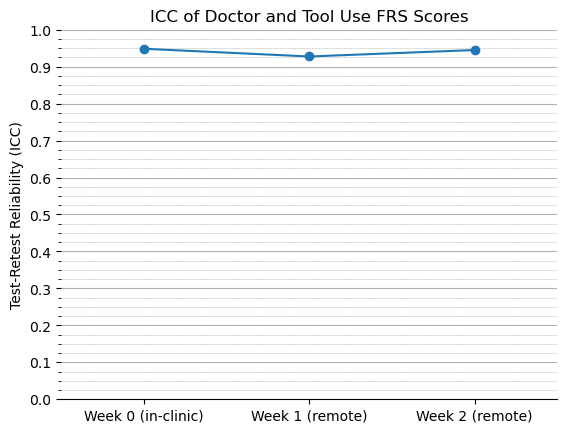

In [1302]:
# Calculate the ICC for the doctor and tool scores
icc_doc_tool_wk0 = calculate_icc_from_df(df, [2,3,5,6], 'Doctor, Week 0 Tool Use Scores')
icc_doc_tool_wk01 = calculate_icc_from_df(df, [2,3,6], 'Doctor, Weeks 0, 1 Tool Use Scores')
icc_doc_tool_wk012 = calculate_icc_from_df(df, [2,3], 'Doctor, Weeks 0, 1, 2 Tool Use Scores')
doc_iccs = [icc_doc_tool_wk0, icc_doc_tool_wk01, icc_doc_tool_wk012]
# print(f"\nDoctor ICCs: {doc_iccs}")
print(f'ICC for Doctor and week 0 Tool Use scores: {icc_doc_tool_wk0:.4f}')
print(f'ICC for Doctor and week 0, 1 Tool Use scores: {icc_doc_tool_wk01:.4f}')
print(f'ICC for Doctor and week 0, 1, 2 Tool Use scores: {icc_doc_tool_wk012:.4f}')
title = 'ICC of Doctor and Tool Use FRS Scores'
session_labels = ['Week 0 (in-clinic)', 'Week 1 (remote)', 'Week 2 (remote)']
plot_icc_over_sessions(doc_iccs, session_labels, plot_title=title)

ICC for Therapist and week 0 Tool Use scores: 0.8516
ICC for Therapist and week 0, 1 Tool Use scores: 0.8571
ICC for Therapist and week 0, 1, 2 Tool Use scores: 0.8914


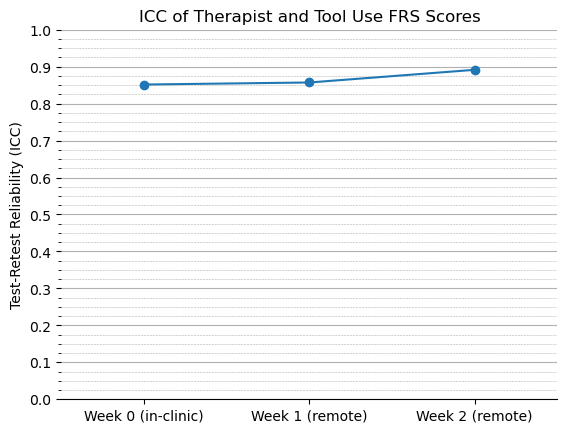

In [1303]:
# Calculate the ICC for the therapist and Tool Use scores
icc_ther_tool_wk0 = calculate_icc_from_df(df, [1,3,5,6], 'Therapist, Week 0 Tool Use Scores')
icc_ther_tool_wk01 = calculate_icc_from_df(df, [1,3,6], 'Therapist, Weeks 0, 1 Tool Use Scores')
icc_ther_tool_wk012 = calculate_icc_from_df(df, [1,3], 'Therapist, Weeks 0, 1, 2 Tool Use Scores')
ther_iccs = [icc_ther_tool_wk0, icc_ther_tool_wk01, icc_ther_tool_wk012]
# print(f"\nTherapist ICCs: {ther_iccs}")
print(f'ICC for Therapist and week 0 Tool Use scores: {icc_ther_tool_wk0:.4f}')
print(f'ICC for Therapist and week 0, 1 Tool Use scores: {icc_ther_tool_wk01:.4f}')
print(f'ICC for Therapist and week 0, 1, 2 Tool Use scores: {icc_ther_tool_wk012:.4f}')

title = 'ICC of Therapist and Tool Use FRS Scores'
session_labels = ['Week 0 (in-clinic)', 'Week 1 (remote)', 'Week 2 (remote)']
plot_icc_over_sessions(ther_iccs, session_labels, plot_title=title)

ICC for Doctor, Therapist, and week 0 Tool Use scores: 0.9013
ICC for Doctor, Therapist, and week 0, 1 Tool Use scores: 0.8904
ICC for Doctor, Therapist, and week 0, 1, 2 Tool Use scores: 0.9096


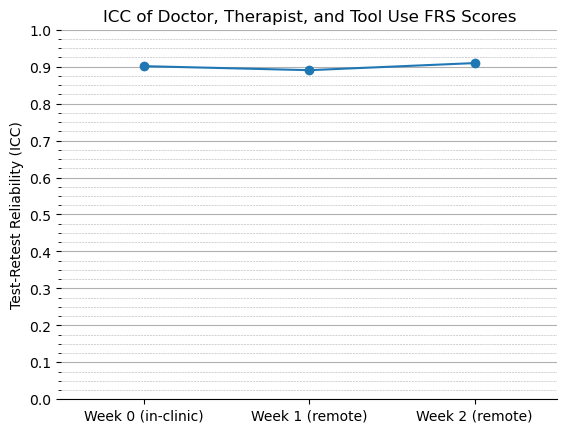

In [1304]:
# Calculate the ICC for the doctor, therapist, and Tool Use scores
icc_doc_ther_tool_wk0 = calculate_icc_from_df(df, [3,5,6], 'Doctor, Therapist, Week 0 Tool Use Scores')
icc_doc_ther_tool_wk01 = calculate_icc_from_df(df, [3,6], 'Doctor, Therapist, Weeks 0, 1 Tool Use Scores')
icc_doc_ther_tool_wk012 = calculate_icc_from_df(df, [3], 'Doctor, Therapist, Weeks 0, 1, 2 Tool Use Scores')
doc_ther_iccs = [icc_doc_ther_tool_wk0, icc_doc_ther_tool_wk01, icc_doc_ther_tool_wk012]
# print(f"\nDoctor, Therapist ICCs: {doc_ther_iccs}")
print(f'ICC for Doctor, Therapist, and week 0 Tool Use scores: {icc_doc_ther_tool_wk0:.4f}')
print(f'ICC for Doctor, Therapist, and week 0, 1 Tool Use scores: {icc_doc_ther_tool_wk01:.4f}')
print(f'ICC for Doctor, Therapist, and week 0, 1, 2 Tool Use scores: {icc_doc_ther_tool_wk012:.4f}')
title = 'ICC of Doctor, Therapist, and Tool Use FRS Scores'
session_labels = ['Week 0 (in-clinic)', 'Week 1 (remote)', 'Week 2 (remote)']
plot_icc_over_sessions(doc_ther_iccs, session_labels, plot_title=title)

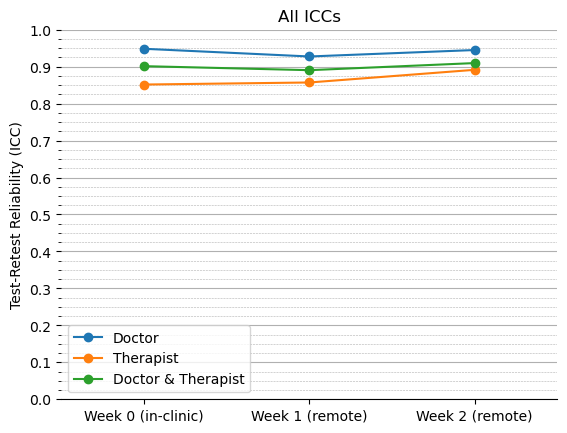

In [1305]:
# Plot the all ICCs on a single graph
combined_iccs = [doc_iccs, ther_iccs, doc_ther_iccs]
session_labels = ['Week 0 (in-clinic)', 'Week 1 (remote)', 'Week 2 (remote)']
icc_labels = ['Doctor', 'Therapist', 'Doctor & Therapist']
plot_icc_combined(combined_iccs, session_labels, plot_title='All ICCs', legend=icc_labels)

In [1306]:
# Calculate the MAE between the doctor and therapist
mae_doc_ther = calculate_mae(df, 1, 2)
print(f"\nMAE between Doctor and Therapist: {mae_doc_ther:.4f}")


MAE between Doctor and Therapist: 0.2917


MAE between Doctor and Week 0 Tool Use Scores: 0.2225
MAE between Doctor and Week 1 Tool Use Scores: 0.3467
MAE between Doctor and Week 2 Tool Use Scores: 0.1500


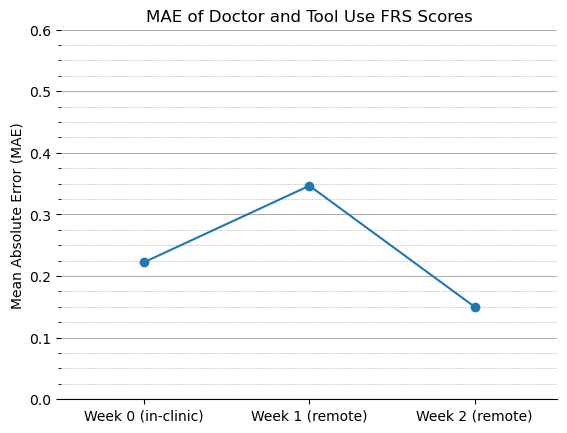

In [1307]:
# Calculate the MAE between the doctor and Tool Use scores
mae_doc_tool_wk0 = calculate_mae(df, 1, 4)
mae_doc_tool_wk1 = calculate_mae(df, 1, 5)
mae_doc_tool_wk2 = calculate_mae(df, 1, 6)
mae_list_doc_tool = [mae_doc_tool_wk0, mae_doc_tool_wk1, mae_doc_tool_wk2]
print(f"MAE between Doctor and Week 0 Tool Use Scores: {mae_doc_tool_wk0:.4f}")
print(f"MAE between Doctor and Week 1 Tool Use Scores: {mae_doc_tool_wk1:.4f}")
print(f"MAE between Doctor and Week 2 Tool Use Scores: {mae_doc_tool_wk2:.4f}")

title = 'MAE of Doctor and Tool Use FRS Scores'
plot_mae(mae_list_doc_tool, ['Week 0 (in-clinic)', 'Week 1 (remote)', 'Week 2 (remote)'], plot_title=title, ymax=0.6)

Aggregate MAE between Doctor and Week 0 Tool Use Scores: 0.2225
Aggregate MAE between Doctor and Weeks 0, 1 Tool Use Scores: 0.2488
Aggregate MAE between Doctor and Weeks 0, 1, 2 Tool Use Scores: 0.2435


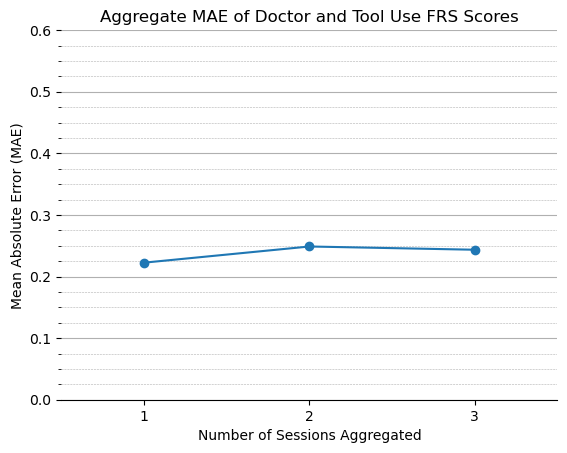

In [1308]:
# Calculate the aggregate MAE between the doctor and Tool Use scores
agg_mae_doc_tool_wk0 = calculate_aggregate_mae(df, 1, 4, 5)
agg_mae_doc_tool_wk01 = calculate_aggregate_mae(df, 1, 4, 6)
agg_mae_doc_tool_wk012 = calculate_aggregate_mae(df, 1, 4, 7)
agg_mae_list_doc_tool = [agg_mae_doc_tool_wk0, agg_mae_doc_tool_wk01, agg_mae_doc_tool_wk012]
print(f"Aggregate MAE between Doctor and Week 0 Tool Use Scores: {agg_mae_doc_tool_wk0:.4f}")
print(f"Aggregate MAE between Doctor and Weeks 0, 1 Tool Use Scores: {agg_mae_doc_tool_wk01:.4f}")
print(f"Aggregate MAE between Doctor and Weeks 0, 1, 2 Tool Use Scores: {agg_mae_doc_tool_wk012:.4f}")

title = 'Aggregate MAE of Doctor and Tool Use FRS Scores'
plot_mae(agg_mae_list_doc_tool, [1, 2, 3], plot_title=title, ymax=0.6, xlabel='Number of Sessions Aggregated')

MAE between Therapist and Week 0 Tool Use Scores: 0.4318
MAE between Therapist and Week 1 Tool Use Scores: 0.4833
MAE between Therapist and Week 2 Tool Use Scores: 0.3800


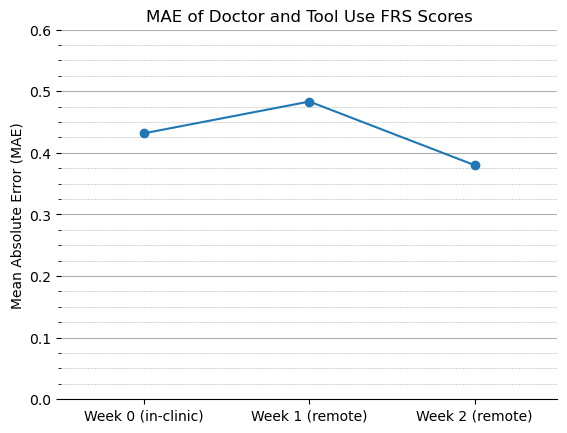

In [1309]:
# Calculate the MAE between the therapist and Tool Use scores
mae_ther_tool_wk0 = calculate_mae(df, 2, 4)
mae_ther_tool_wk1 = calculate_mae(df, 2, 5)
mae_ther_tool_wk2 = calculate_mae(df, 2, 6)
mae_list_ther_tool = [mae_ther_tool_wk0, mae_ther_tool_wk1, mae_ther_tool_wk2]
print(f"MAE between Therapist and Week 0 Tool Use Scores: {mae_ther_tool_wk0:.4f}")
print(f"MAE between Therapist and Week 1 Tool Use Scores: {mae_ther_tool_wk1:.4f}")
print(f"MAE between Therapist and Week 2 Tool Use Scores: {mae_ther_tool_wk2:.4f}")

title = 'MAE of Doctor and Tool Use FRS Scores'
plot_mae(mae_list_ther_tool, ['Week 0 (in-clinic)', 'Week 1 (remote)', 'Week 2 (remote)'], plot_title=title, ymax=0.6)

Aggregate MAE between Therapist and Week 0 Tool Use Scores: 0.4318
Aggregate MAE between Therapist and Weeks 0, 1 Tool Use Scores: 0.4551
Aggregate MAE between Therapist and Weeks 0, 1, 2 Tool Use Scores: 0.4378


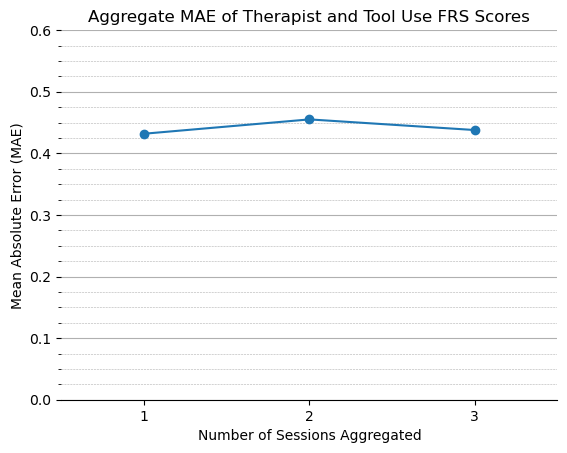

In [1310]:
# Calculate the aggregate MAE between the therapist and Tool Use scores
agg_mae_ther_tool_wk0 = calculate_aggregate_mae(df, 2, 4, 5)  
agg_mae_ther_tool_wk01 = calculate_aggregate_mae(df, 2, 4, 6)
agg_mae_ther_tool_wk012 = calculate_aggregate_mae(df, 2, 4, 7)
agg_mae_list_ther_tool = [agg_mae_ther_tool_wk0, agg_mae_ther_tool_wk01, agg_mae_ther_tool_wk012]
print(f"Aggregate MAE between Therapist and Week 0 Tool Use Scores: {agg_mae_ther_tool_wk0:.4f}")
print(f"Aggregate MAE between Therapist and Weeks 0, 1 Tool Use Scores: {agg_mae_ther_tool_wk01:.4f}")
print(f"Aggregate MAE between Therapist and Weeks 0, 1, 2 Tool Use Scores: {agg_mae_ther_tool_wk012:.4f}")

title = 'Aggregate MAE of Therapist and Tool Use FRS Scores'
plot_mae(agg_mae_list_ther_tool, [1, 2, 3], plot_title=title, ymax=0.6, xlabel='Number of Sessions Aggregated')

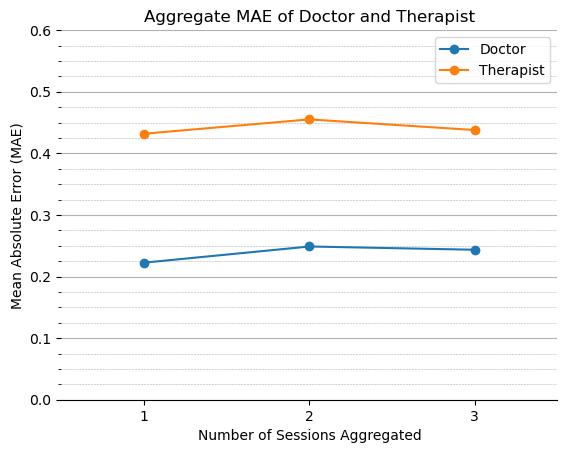

In [1311]:
# Plot a combined Aggregate MAE graph
combined_agg_mae = [agg_mae_list_doc_tool, agg_mae_list_ther_tool]
plot_mae_combined(combined_agg_mae, [1, 2, 3], plot_title='Aggregate MAE of Doctor and Therapist', ymax=0.6, xlabel='Number of Sessions Aggregated', legend=['Doctor', 'Therapist'])